In [60]:
use_gpu = True

# 测试所有三种模型
model_types = ["baseline", "baseline_large", "vit"]

# 模型路径配置（使用训练好的最佳模型）
model_paths = {
    "baseline": "../pt/baseline/best.pt",
    "baseline_large": "../pt/baseline_large/best.pt",
    "vit": "../pt/vit/best.pt",
}

# 选股阈值（为每个模型单独设置）
thresholds = {
    "baseline": 0.58,
    "baseline_large": 0.58,
    "vit": 0.50,  # ViT 模型使用较低阈值
}

# 存储所有模型的测试结果
all_test_results = {}

In [61]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')
from utils.gpu_tools import *
os.environ["CUDA_LAUNCH_BLOCKING"] = '0'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

## load data

In [62]:
year_list = np.arange(2001,2020,1)

In [63]:
images = []
label_df = []
for year in year_list:
    images.append(np.memmap(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(1403975, 64, 60)
(1403975, 8)


## build dataset

In [64]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [65]:
dataset = MyDataset(images, (label_df.Ret_20d > 0).values)

In [66]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

## Define Test Functions

In [67]:
from models import baseline, baseline_large, vit
device = 'cuda' if use_gpu else 'cpu'
print(f"Using device: {device}")

def eval_loop(dataloader, net, loss_fn, model_name="model"):
    """
    评估循环
    
    Returns:
        running_loss: 平均 loss
        predict: 预测结果
        target: 真实标签
    """
    running_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    
    with torch.no_grad():
        with tqdm(dataloader, desc=f"[{model_name}] Eval") as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'loss': f'{running_loss:.4f}'})
            
    return running_loss, torch.cat(predict), torch.cat(target)

def calculate_strategy_returns(label_df, predict_logit, threshold=0.58):
    """
    计算策略收益
    
    Returns:
        ret_baseline: 基准收益（买入所有股票）
        ret_strategy: 策略收益（根据模型选股）
    """
    # Baseline: 买入所有股票
    ret_baseline = label_df.groupby(['Date'])['Ret_20d'].mean()
    
    # Strategy: 只买入预测概率 > threshold 的股票
    mask = predict_logit > threshold
    label_filtered = label_df[mask]
    if len(label_filtered) > 0:
        ret_strategy = label_filtered.groupby(['Date'])['Ret_20d'].mean()
    else:
        ret_strategy = pd.Series(dtype=float)
    
    return ret_baseline, ret_strategy

def test_single_model(model_type, model_path, test_dataloader, label_df_original, device, threshold=0.58):
    """
    测试单个模型
    
    Returns:
        results: 包含测试结果的字典
    """
    print(f"\n{'='*60}")
    print(f"Testing Model: {model_type}")
    print(f"Model Path: {model_path}")
    print(f"{'='*60}")
    
    # 检查模型文件是否存在
    if not os.path.exists(model_path):
        print(f"  ⚠️ Model file not found: {model_path}")
        return None
    
    # 加载模型
    net = torch.load(model_path, weights_only=False)
    net = net.to(device)
    
    # 统计参数量
    if hasattr(net, 'module'):
        num_params = sum(p.numel() for p in net.module.parameters())
    else:
        num_params = sum(p.numel() for p in net.parameters())
    print(f"Model Parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    
    # 评估
    loss_fn = nn.CrossEntropyLoss()
    test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn, model_type)
    
    # 计算预测概率
    predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:, 1]).cpu().numpy()
    
    # 计算准确率
    y_pred_class = y_pred.argmax(dim=1).cpu().numpy()
    y_target_np = y_target.cpu().numpy()
    accuracy = (y_pred_class == y_target_np).mean()
    
    # 计算策略收益
    label_df_copy = label_df_original.copy()
    ret_baseline, ret_strategy = calculate_strategy_returns(label_df_copy, predict_logit, threshold)
    
    # 计算累计收益
    cum_ret_baseline = (ret_baseline + 1).cumprod().iloc[-1] if len(ret_baseline) > 0 else 1.0
    cum_ret_strategy = (ret_strategy + 1).cumprod().iloc[-1] if len(ret_strategy) > 0 else 1.0
    
    # 计算选中的股票数量
    num_selected = (predict_logit > threshold).sum()
    selection_ratio = num_selected / len(predict_logit) * 100
    
    results = {
        "model_type": model_type,
        "num_params": num_params,
        "test_loss": test_loss,
        "accuracy": accuracy,
        "threshold": threshold,
        "num_selected": int(num_selected),
        "selection_ratio": selection_ratio,
        "cum_ret_baseline": cum_ret_baseline,
        "cum_ret_strategy": cum_ret_strategy,
        "excess_return": cum_ret_strategy - cum_ret_baseline,
        "predict_logit": predict_logit,
        "ret_baseline": ret_baseline,
        "ret_strategy": ret_strategy,
    }
    
    print(f"\nResults:")
    print(f"  Test Loss: {test_loss:.6f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Selected Stocks: {num_selected:,} ({selection_ratio:.2f}%)")
    print(f"  Cumulative Return (Baseline): {cum_ret_baseline:.4f}")
    print(f"  Cumulative Return (Strategy): {cum_ret_strategy:.4f}")
    print(f"  Excess Return: {cum_ret_strategy - cum_ret_baseline:.4f}")
    
    # 清理 GPU 缓存
    del net
    torch.cuda.empty_cache()
    
    return results

Using device: cuda


In [68]:
# 保存原始 label_df 的副本（用于每个模型的测试）
label_df_original = label_df.copy()

In [69]:
# 测试所有模型
print("\n" + "#"*70)
print("# Testing All Models")
print("#"*70)

for model_type in model_types:
    model_path = model_paths[model_type]
    model_threshold = thresholds[model_type]
    
    results = test_single_model(
        model_type=model_type,
        model_path=model_path,
        test_dataloader=test_dataloader,
        label_df_original=label_df_original,
        device=device,
        threshold=model_threshold
    )
    
    if results is not None:
        all_test_results[model_type] = results

print("\n\n" + "="*70)
print("All Models Testing Complete!")
print("="*70)


######################################################################
# Testing All Models
######################################################################

Testing Model: baseline
Model Path: ../pt/baseline/best.pt
Model Parameters: 708,866 (0.71M)


[baseline] Eval:   0%|          | 0/686 [00:00<?, ?it/s]

[baseline] Eval: 100%|██████████| 686/686 [00:25<00:00, 26.88it/s, loss=0.6942]



Results:
  Test Loss: 0.694193
  Accuracy: 0.5158
  Selected Stocks: 25,922 (1.85%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 19.8617
  Excess Return: 16.6825

Testing Model: baseline_large
Model Path: ../pt/baseline_large/best.pt
Model Parameters: 10,233,602 (10.23M)


[baseline_large] Eval: 100%|██████████| 686/686 [00:32<00:00, 20.81it/s, loss=0.6926]



Results:
  Test Loss: 0.692632
  Accuracy: 0.5210
  Selected Stocks: 62,823 (4.47%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 17.1079
  Excess Return: 13.9287

Testing Model: vit
Model Path: ../pt/vit/best.pt
Model Parameters: 10,821,314 (10.82M)


[vit] Eval: 100%|██████████| 686/686 [00:54<00:00, 12.51it/s, loss=0.6935]



Results:
  Test Loss: 0.693470
  Accuracy: 0.4984
  Selected Stocks: 326,761 (23.27%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 2.8440
  Excess Return: -0.3352


All Models Testing Complete!


## Results Summary

In [70]:
# 汇总所有模型的测试结果
print("\n" + "="*100)
print("Test Results Summary")
print("="*100)
print(f"{'Model':<18} {'Params':<12} {'Test Loss':<12} {'Accuracy':<10} {'Selected':<12} {'Cum Ret':<12} {'Excess Ret':<12}")
print("-"*100)

for model_type, results in all_test_results.items():
    print(f"{model_type:<18} {results['num_params']/1e6:.2f}M{'':<5} {results['test_loss']:<12.6f} {results['accuracy']:<10.4f} {results['selection_ratio']:.1f}%{'':<6} {results['cum_ret_strategy']:<12.4f} {results['excess_return']:<12.4f}")

print("="*100)


Test Results Summary
Model              Params       Test Loss    Accuracy   Selected     Cum Ret      Excess Ret  
----------------------------------------------------------------------------------------------------
baseline           0.71M      0.694193     0.5158     1.8%       19.8617      16.6825     
baseline_large     10.23M      0.692632     0.5210     4.5%       17.1079      13.9287     
vit                10.82M      0.693470     0.4984     23.3%       2.8440       -0.3352     


In [71]:
# 生成 Markdown 格式的结果表格
print("\n## Test Results (Markdown Format)\n")
print("| Model | Parameters | Test Loss | Accuracy | Selection % | Cum Return | Excess Return |")
print("|-------|------------|-----------|----------|-------------|------------|---------------|")
for model_type, results in all_test_results.items():
    print(f"| {model_type} | {results['num_params']/1e6:.2f}M | {results['test_loss']:.6f} | {results['accuracy']:.4f} | {results['selection_ratio']:.1f}% | {results['cum_ret_strategy']:.4f} | {results['excess_return']:.4f} |")


## Test Results (Markdown Format)

| Model | Parameters | Test Loss | Accuracy | Selection % | Cum Return | Excess Return |
|-------|------------|-----------|----------|-------------|------------|---------------|
| baseline | 0.71M | 0.694193 | 0.5158 | 1.8% | 19.8617 | 16.6825 |
| baseline_large | 10.23M | 0.692632 | 0.5210 | 4.5% | 17.1079 | 13.9287 |
| vit | 10.82M | 0.693470 | 0.4984 | 23.3% | 2.8440 | -0.3352 |


## Plot Performance Comparison

In [72]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

### Cumulative Return Comparison (All Models)

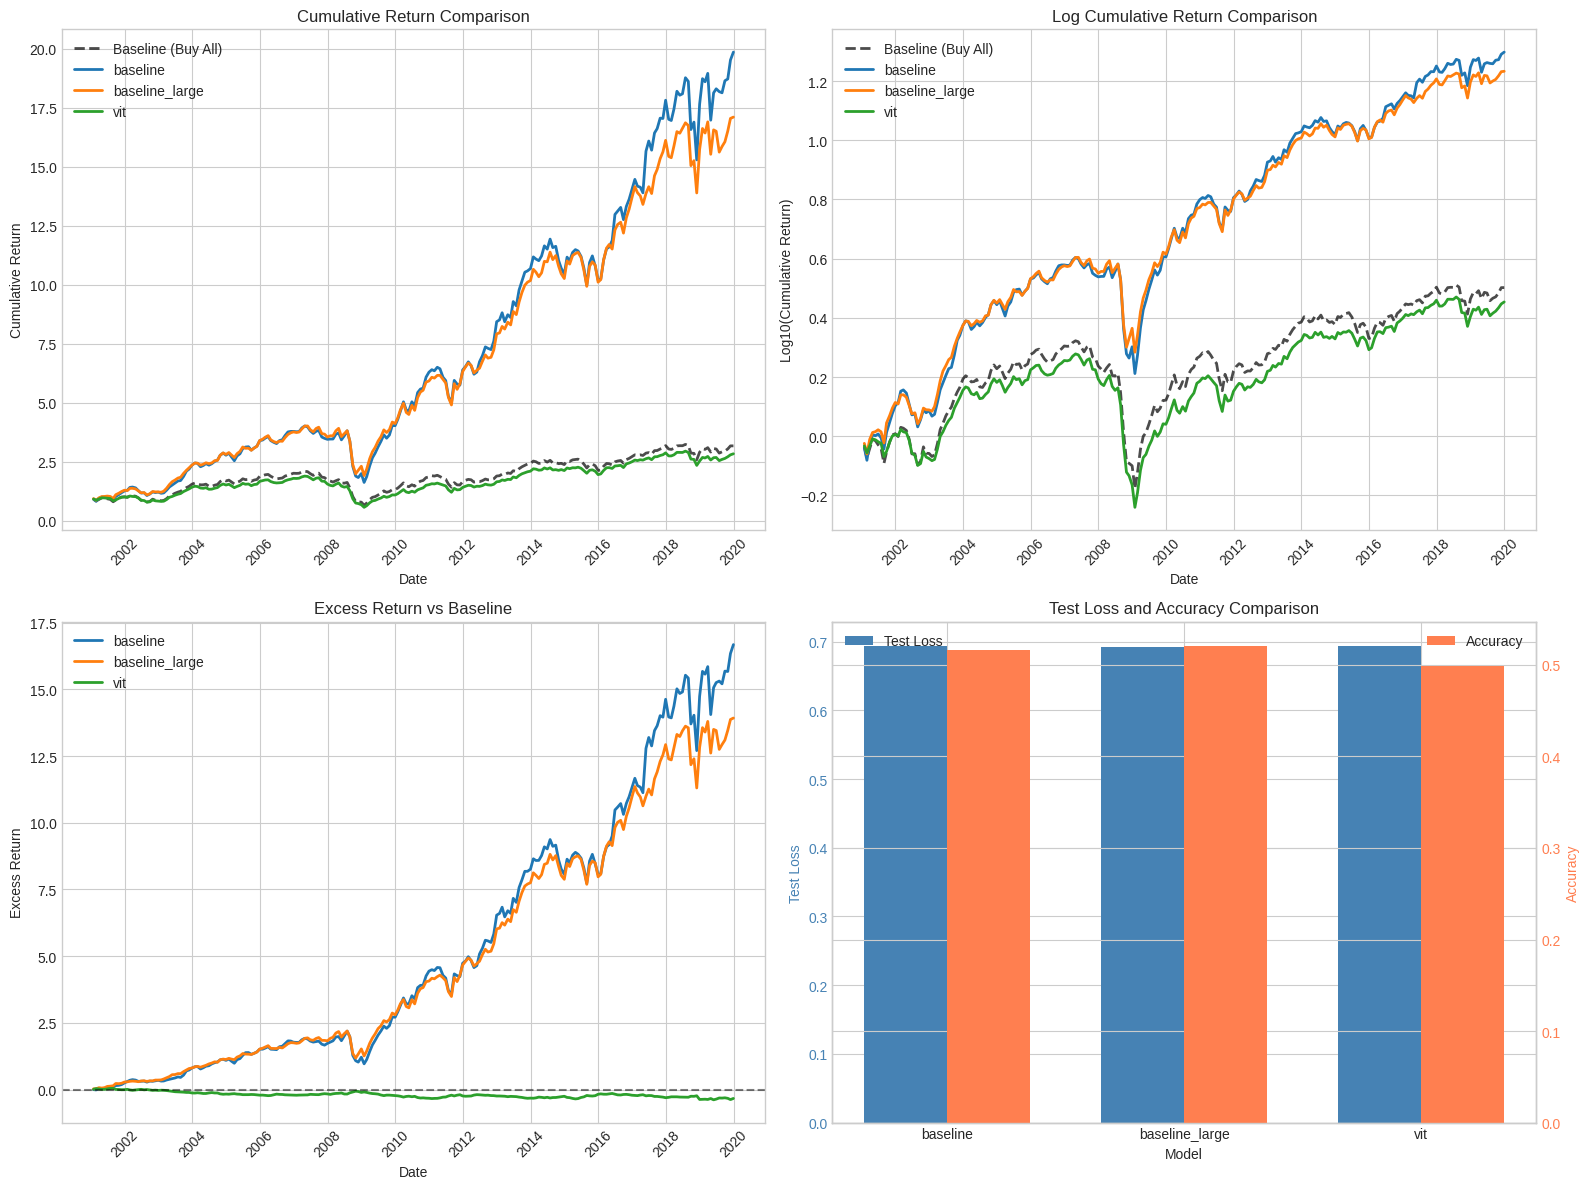


Comparison plot saved to: ../pic/test_comparison.png

Thresholds used:
  baseline: threshold=0.58, selection=1.85%
  baseline_large: threshold=0.58, selection=4.47%
  vit: threshold=0.50, selection=23.27%


In [73]:
# 绘制累计收益对比图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 累计收益对比（所有模型）
ax1 = axes[0, 0]
# 绘制 baseline（买入所有股票）
if len(all_test_results) > 0:
    first_model = list(all_test_results.keys())[0]
    ret_baseline = all_test_results[first_model]['ret_baseline']
    cum_baseline = (ret_baseline + 1).cumprod()
    ax1.plot(cum_baseline.index, cum_baseline.values, 'k--', label='Baseline (Buy All)', linewidth=2, alpha=0.7)

# 绘制每个模型的策略收益
for i, (model_type, results) in enumerate(all_test_results.items()):
    ret_strategy = results['ret_strategy']
    if len(ret_strategy) > 0:
        cum_strategy = (ret_strategy + 1).cumprod()
        ax1.plot(cum_strategy.index, cum_strategy.values, label=f'{model_type}', linewidth=2, color=colors[i % len(colors)])
    else:
        # 对于没有选中股票的模型，绘制一条水平线表示无收益
        ax1.axhline(y=1.0, label=f'{model_type} (No Selection)', linewidth=2, linestyle=':', color=colors[i % len(colors)], alpha=0.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Return Comparison')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2. 对数累计收益对比
ax2 = axes[0, 1]
if len(all_test_results) > 0:
    log_cum_baseline = np.log10(cum_baseline)
    ax2.plot(log_cum_baseline.index, log_cum_baseline.values, 'k--', label='Baseline (Buy All)', linewidth=2, alpha=0.7)

for i, (model_type, results) in enumerate(all_test_results.items()):
    ret_strategy = results['ret_strategy']
    if len(ret_strategy) > 0:
        log_cum_strategy = np.log10((ret_strategy + 1).cumprod())
        ax2.plot(log_cum_strategy.index, log_cum_strategy.values, label=f'{model_type}', linewidth=2, color=colors[i % len(colors)])
    else:
        ax2.axhline(y=0, label=f'{model_type} (No Selection)', linewidth=2, linestyle=':', color=colors[i % len(colors)], alpha=0.5)

ax2.set_xlabel('Date')
ax2.set_ylabel('Log10(Cumulative Return)')
ax2.set_title('Log Cumulative Return Comparison')
ax2.legend(loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# 3. 超额收益对比
ax3 = axes[1, 0]
for i, (model_type, results) in enumerate(all_test_results.items()):
    ret_strategy = results['ret_strategy']
    ret_baseline = results['ret_baseline']
    
    if len(ret_strategy) > 0:
        # 对齐日期
        common_dates = ret_strategy.index.intersection(ret_baseline.index)
        excess_ret = (ret_strategy.loc[common_dates] + 1).cumprod() - (ret_baseline.loc[common_dates] + 1).cumprod()
        ax3.plot(excess_ret.index, excess_ret.values, label=f'{model_type}', linewidth=2, color=colors[i % len(colors)])
    else:
        # 对于没有选中股票的模型，超额收益等于 -baseline 的累计收益
        excess_ret = 1.0 - (ret_baseline + 1).cumprod()
        ax3.plot(excess_ret.index, excess_ret.values, label=f'{model_type} (No Selection)', linewidth=2, linestyle=':', color=colors[i % len(colors)], alpha=0.5)

ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Date')
ax3.set_ylabel('Excess Return')
ax3.set_title('Excess Return vs Baseline')
ax3.legend(loc='upper left')
ax3.tick_params(axis='x', rotation=45)

# 4. 测试指标对比（柱状图）
ax4 = axes[1, 1]
model_names = list(all_test_results.keys())
test_losses = [all_test_results[m]['test_loss'] for m in model_names]
accuracies = [all_test_results[m]['accuracy'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax4.bar(x - width/2, test_losses, width, label='Test Loss', color='steelblue')
ax4.set_ylabel('Test Loss', color='steelblue')
ax4.tick_params(axis='y', labelcolor='steelblue')

ax4_twin = ax4.twinx()
bars2 = ax4_twin.bar(x + width/2, accuracies, width, label='Accuracy', color='coral')
ax4_twin.set_ylabel('Accuracy', color='coral')
ax4_twin.tick_params(axis='y', labelcolor='coral')

ax4.set_xlabel('Model')
ax4.set_title('Test Loss and Accuracy Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(model_names)
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../pic/test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison plot saved to: ../pic/test_comparison.png")
print("\nThresholds used:")
for model_type in model_types:
    t = thresholds[model_type]
    sel_ratio = all_test_results[model_type]['selection_ratio'] if model_type in all_test_results else 0
    print(f"  {model_type}: threshold={t:.2f}, selection={sel_ratio:.2f}%")


### Number of Stocks Selected Over Time

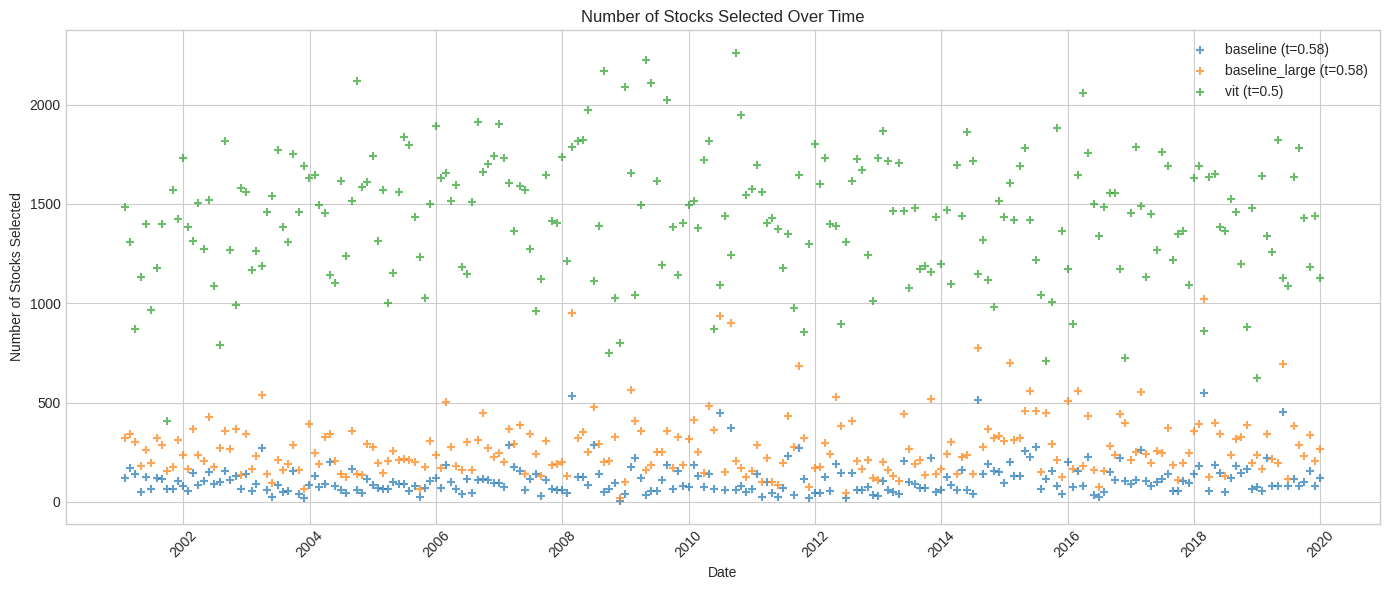


Stocks selected plot saved to: ../pic/stocks_selected.png


In [74]:
# 绘制每个模型随时间选中的股票数量
fig, ax = plt.subplots(figsize=(14, 6))

for i, (model_type, results) in enumerate(all_test_results.items()):
    predict_logit = results['predict_logit']
    model_threshold = results['threshold']  # 使用每个模型对应的阈值
    mask = predict_logit > model_threshold
    
    # 获取选中股票的日期分布
    label_filtered = label_df_original[mask]
    stocks_per_date = label_filtered.groupby(['Date']).size()
    
    ax.scatter(stocks_per_date.index, stocks_per_date.values, 
               marker='+', label=f'{model_type} (t={model_threshold})', alpha=0.7, s=30)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Stocks Selected')
ax.set_title('Number of Stocks Selected Over Time')
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../pic/stocks_selected.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nStocks selected plot saved to: ../pic/stocks_selected.png")

## Save Results to JSON

In [75]:
import json

# 保存结果到 JSON（排除不可序列化的对象）
results_for_json = {}
for model_type, results in all_test_results.items():
    results_for_json[model_type] = {
        "model_type": results["model_type"],
        "num_params": results["num_params"],
        "test_loss": results["test_loss"],
        "accuracy": float(results["accuracy"]),
        "threshold": results["threshold"],
        "num_selected": results["num_selected"],
        "selection_ratio": results["selection_ratio"],
        "cum_ret_baseline": float(results["cum_ret_baseline"]),
        "cum_ret_strategy": float(results["cum_ret_strategy"]),
        "excess_return": float(results["excess_return"]),
    }

with open('../pt/test_results.json', 'w') as f:
    json.dump(results_for_json, f, indent=2)

print("Results saved to: ../pt/test_results.json")
print(json.dumps(results_for_json, indent=2))


Results saved to: ../pt/test_results.json
{
  "baseline": {
    "model_type": "baseline",
    "num_params": 708866,
    "test_loss": 0.6941931889320337,
    "accuracy": 0.5157876742819495,
    "threshold": 0.58,
    "num_selected": 25922,
    "selection_ratio": 1.8463291725280009,
    "cum_ret_baseline": 3.1791877065489427,
    "cum_ret_strategy": 19.861671007656867,
    "excess_return": 16.682483301107922
  },
  "baseline_large": {
    "model_type": "baseline_large",
    "num_params": 10233602,
    "test_loss": 0.6926317815465293,
    "accuracy": 0.521027083815595,
    "threshold": 0.58,
    "num_selected": 62823,
    "selection_ratio": 4.474652326430314,
    "cum_ret_baseline": 3.1791877065489427,
    "cum_ret_strategy": 17.1078770583634,
    "excess_return": 13.928689351814457
  },
  "vit": {
    "model_type": "vit",
    "num_params": 10821314,
    "test_loss": 0.693470492503414,
    "accuracy": 0.49838494275182965,
    "threshold": 0.5,
    "num_selected": 326761,
    "selection_ra

In [76]:
# 找出最佳模型
if len(all_test_results) > 0:
    best_model = max(all_test_results.keys(), key=lambda x: all_test_results[x]['cum_ret_strategy'])
    best_results = all_test_results[best_model]
    
    print("\n" + "="*60)
    print("Best Model Summary")
    print("="*60)
    print(f"Best Model: {best_model}")
    print(f"Test Loss: {best_results['test_loss']:.6f}")
    print(f"Accuracy: {best_results['accuracy']:.4f}")
    print(f"Cumulative Return: {best_results['cum_ret_strategy']:.4f}")
    print(f"Excess Return: {best_results['excess_return']:.4f}")
    print("="*60)


Best Model Summary
Best Model: baseline
Test Loss: 0.694193
Accuracy: 0.5158
Cumulative Return: 19.8617
Excess Return: 16.6825


## Output Files Summary

In [77]:
print("\nOutput Files:")
print("-" * 40)
print("📊 Plots:")
print("  - ../pic/test_comparison.png")
print("  - ../pic/stocks_selected.png")
print("\n📄 Data:")
print("  - ../pt/test_results.json")
print("\n✅ Testing Complete!")


Output Files:
----------------------------------------
📊 Plots:
  - ../pic/test_comparison.png
  - ../pic/stocks_selected.png

📄 Data:
  - ../pt/test_results.json

✅ Testing Complete!


In [78]:
# End of test notebook